In [ ]:
%load_ext autoreload
%autoreload 2

# Training

> The `training.token_classification` module contains the core bits required for training transformers on token classification tasks (e.g., Named entity recognition (NER), Part-of-speech tagging (POS), etc...)

In [ ]:
# |default_exp training.token_classification
# |default_cls_lvl 3

In [ ]:
# |export
from __future__ import annotations

import ast, gc, importlib, sys, traceback

from accelerate.logging import get_logger
from dataclasses import dataclass
from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.imports import *
from fastai.learner import *
from fastai.torch_core import *
from fastai.torch_imports import *
from seqeval import metrics as seq_metrics
from transformers import PreTrainedTokenizerBase, PreTrainedModel
from transformers import logging as hf_logging

from blurr.data.core import first_blurr_tfm
from blurr.training.core import Blearner
from blurr.data.token_classification import TokenClassTextInput, get_token_labels_from_input_ids, get_word_labels_from_token_labels

In [ ]:
# |hide
import pdb, nbdev

from datasets import concatenate_datasets, load_dataset, Value
from fastai.data.block import CategoryBlock, ColReader, ColSplitter, DataBlock, FuncSplitter, MultiCategoryBlock
from fastai.data.transforms import DataLoader, DataLoaders, Datasets, ItemTransform, TfmdDL
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.metrics import accuracy
from fastai.optimizer import Adam, params
from fastai.text.data import SortedDL
from fastcore.test import *

from blurr.data.core import *
from blurr.data.token_classification import *
from blurr.training.core import *
from blurr.utils import *

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()
logger = get_logger(__name__)

load_dotenv()

False

In [ ]:
# |hide
# |notest
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: NVIDIA GeForce RTX 3090


In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.13.1
fastai: 2.7.11
transformers: 4.26.1


## Setup

We'll use a subset of `conll2003` to demonstrate how to configure your blurr code for token classification

In [ ]:
conll2003_dsd = load_dataset("conll2003")
conll2003_dsd

Found cached dataset conll2003 (/home/wgilliam/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

We need to get a list of the distinct entities we want to predict. If they are represented as list in their raw/readable form in another attribute/column in our dataset, we could use something like this to build a sorted list of distinct values as such: 

`label_names = sorted(list(set([lbls for sublist in germ_eval_df.labels.tolist() for lbls in sublist])))`

Fortunately, the `conll2003` dataset allows us to get at this list directly using the code below.

In [ ]:
print(conll2003_dsd["train"].features["chunk_tags"].feature.names[:20])
print(conll2003_dsd["train"].features["ner_tags"].feature.names[:20])
print(conll2003_dsd["train"].features["pos_tags"].feature.names[:20])

['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP']
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS']


In [ ]:
print(conll2003_dsd["train"][0]["tokens"])
print(conll2003_dsd["train"][0]["ner_tags"])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[3, 0, 7, 0, 0, 0, 7, 0, 0]


In [ ]:
label_names = conll2003_dsd["train"].features["ner_tags"].feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

Let's prepare both a Hugging Face `Dataset`s and `DataFrame`s for illustrating how each can be used in BLURR

In [ ]:
# build HF `Dataset` objects
train_ds = conll2003_dsd["train"].add_column("is_valid", [False] * len(conll2003_dsd["train"])).shuffle().select(range(10000))
valid_ds = conll2003_dsd["validation"].add_column("is_valid", [True] * len(conll2003_dsd["validation"])).shuffle().select(range(2000))
conll2003_ds = concatenate_datasets([train_ds, valid_ds])

# build a `DataFrame` representation as well
conll2003_df = pd.DataFrame(conll2003_ds)

print(len(train_ds), len(valid_ds))
print(len(conll2003_df[conll2003_df["is_valid"] == False]), len(conll2003_df[conll2003_df["is_valid"] == True]))
conll2003_df.head()

10000 2000
10000 2000


,id,tokens,pos_tags,chunk_tags,ner_tags,is_valid
0,989,"[43., Croatia, 7.75]","[11, 22, 11]","[11, 12, 12]","[0, 5, 0]",False
1,2236,"[Adrian, Warner]","[22, 22]","[11, 12]","[1, 2]",False
2,9919,"[The, president, of, the, Nasdaq, ,, Alfred, Berkeley, ,, was, to, hold, a, news, conference, Wednesday, afternoon, to, elaborate, on, the, new, rules, ', effects, on, the, market, ,, the, second, largest, in, the, world, .]","[12, 21, 15, 12, 22, 6, 22, 22, 6, 38, 35, 37, 12, 21, 21, 22, 21, 35, 37, 15, 12, 16, 24, 27, 24, 15, 12, 21, 6, 12, 16, 18, 15, 12, 21, 7]","[11, 12, 13, 11, 12, 0, 11, 12, 0, 21, 21, 22, 11, 12, 12, 11, 12, 21, 22, 13, 11, 12, 12, 11, 12, 13, 11, 12, 0, 11, 12, 12, 13, 11, 12, 0]","[0, 0, 0, 0, 7, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",False
3,8942,"[The, Chechens, said, a, renegade, group, seized, the, weapons, and, said, on, Monday, they, had, all, been, returned, .]","[12, 23, 38, 12, 21, 21, 38, 12, 24, 10, 38, 15, 22, 28, 38, 12, 40, 40, 7]","[11, 12, 21, 11, 12, 12, 21, 11, 12, 0, 21, 13, 11, 11, 21, 0, 21, 22, 0]","[0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",False
4,8898,"[But, communications, at, this, time, of, year, are, very, difficult, because, of, rains, and, a, lack, of, power, ,, "", he, added, .]","[10, 24, 15, 12, 21, 15, 21, 41, 30, 16, 15, 15, 24, 10, 12, 21, 15, 21, 6, 0, 28, 38, 7]","[0, 11, 13, 11, 12, 13, 11, 21, 1, 2, 13, 14, 11, 0, 11, 12, 13, 11, 0, 0, 11, 21, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",False


## Base API


### `TokenClassMetricsCallback` - 

In [ ]:
# |export
def calculate_token_class_metrics(pred_toks, targ_toks, metric_key):
    if metric_key == "accuracy":
        return seq_metrics.accuracy_score(targ_toks, pred_toks)

    if metric_key == "precision":
        return seq_metrics.precision_score(targ_toks, pred_toks)

    if metric_key == "recall":
        return seq_metrics.recall_score(targ_toks, pred_toks)

    if metric_key == "f1":
        return seq_metrics.f1_score(targ_toks, pred_toks)

    if metric_key == "classification_report":
        return seq_metrics.classification_report(targ_toks, pred_toks)

In [ ]:
nbdev.show_doc(calculate_token_class_metrics, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/training/token_classification.py#L37){target="_blank" style="float:right; font-size:smaller"}

### calculate_token_class_metrics

>      calculate_token_class_metrics (pred_toks, targ_toks, metric_key)

In [ ]:
# |export
class TokenClassMetricsCallback(Callback):
    """
    A fastai friendly callback that includes accuracy, precision, recall, and f1 metrics using the
    `seqeval` library.  Additionally, this metric knows how to *not* include your 'ignore_token' in it's
    calculations.

    See [here](https://github.com/chakki-works/seqeval) for more information on `seqeval`.
    """

    def __init__(
        self,
        # The Hugging Face tokenizer used by your model
        hf_tokenizer: PreTrainedTokenizerBase,
        # The names of your labels
        label_names: list[str],
        # The token classification metrics to inclue
        tok_metrics: list[str] = ["accuracy", "precision", "recall", "f1"],
        # The token ID for labels that should be ignored when calculating metrics (e.g., CLS, SEP, PAD token Ids)
        ignore_token_id: int = CrossEntropyLossFlat().ignore_index,
        **kwargs,
    ):
        self.run_before = Recorder

        store_attr()
        self.custom_metrics_dict = {k: None for k in tok_metrics}
        self.do_setup = True

    def setup(self):
        # one time setup code here.
        if not self.do_setup:
            return

        # add custom text generation specific metrics
        custom_metric_keys = self.custom_metrics_dict.keys()
        custom_metrics = L([ValueMetric(partial(self.metric_value, metric_key=k), k) for k in custom_metric_keys])
        self.learn.metrics = self.learn.metrics + custom_metrics
        self.learn.token_classification_report = None

        self.do_setup = False

    def before_fit(self):
        self.setup()

    # --- batch begin/after phases ---
    def before_batch(self):
        pass

    def after_batch(self):
        if self.training or self.learn.y is None:
            return

        # do this only for validation set
        preds = self.pred.argmax(dim=-1)
        targs = self.yb[0]  # yb is TensorText tuple, item 0 is the data

        targets_list = [[self.label_names[l] for l in trg if l != self.ignore_token_id] for trg in targs]
        preds_list = [[self.label_names[p] for (p, l) in zip(pred, trg) if l != self.ignore_token_id] for pred, trg in zip(preds, targs)]

        self.results += [(res[0], res[1]) for res in zip(preds_list, targets_list)]

    # --- validation begin/after phases ---
    def before_validate(self):
        self.results = []

    def after_validate(self):
        if len(self.results) < 1:
            return

        preds, targs = map(list, zip(*self.results))
        for k in self.custom_metrics_dict.keys():
            self.custom_metrics_dict[k] = calculate_token_class_metrics(targs, preds, metric_key=k)

        try:
            self.learn.token_classification_report = calculate_token_class_metrics(targs, preds, "classification_report")
        except ZeroDivisionError as err:
            print(f"Couldn't calcualte classification report: {err}")

    # --- for ValueMetric metrics ---
    def metric_value(self, metric_key):
        return self.custom_metrics_dict[metric_key]

## Base API: Examples

This section demonstrates how you can use standard `Dataset` objects (PyTorch and Hugging Face) to build PyTorch `DataLoader`s

### PyTorch

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Dataset`s (PyTorch)

In [ ]:
# define our subword tokenized labeling strategy
labeling_strat = BILabelingStrategy(hf_tokenizer=hf_tokenizer, label_names=label_names)

tokenize_func = partial(
    tokenclass_tokenize_func, hf_tokenizer=hf_tokenizer, labeling_strategy=labeling_strat, words_attr="tokens", word_labels_attr="ner_tags"
)
proc_train_ds = train_ds.map(tokenize_func, batched=True, remove_columns=train_ds.column_names)
proc_valid_ds = valid_ds.map(tokenize_func, batched=True, remove_columns=valid_ds.column_names)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTokenClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        return item


# build our PyTorch training and validation Datasets
pt_proc_train_ds = HFTokenClassificationDataset(proc_train_ds, hf_tokenizer=hf_tokenizer)
pt_proc_valid_ds = HFTokenClassificationDataset(proc_valid_ds, hf_tokenizer=hf_tokenizer)

#### Step 3: `DataLoaders` (PyTorch)

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TokenClassTextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [TokenClassMetricsCallback(hf_tokenizer=hf_tokenizer, label_names=label_names)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    cbs=learn_cbs,
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
b = next(iter(dls.valid))
preds = learn.model(to_device(b[0], hf_model.device))
len(preds), type(preds), preds.keys()

(2,
 transformers.modeling_outputs.TokenClassifierOutput,
 odict_keys(['loss', 'logits']))

In [ ]:
len(b), len(b[0]), b[0]["input_ids"].shape, len(b[1]), b[1].shape, preds.logits.shape

(2, 4, torch.Size([8, 130]), 8, torch.Size([8, 130]), torch.Size([8, 130, 9]))

In [ ]:
print(preds.logits.view(-1, preds.logits.shape[-1]).shape, b[1].view(-1).shape)
test_eq(preds.logits.view(-1, preds.logits.shape[-1]).shape[0], b[1].view(-1).shape[0])

torch.Size([1040, 9]) torch.Size([1040])


#### Step 5: Train

SuggestedLRs(minimum=0.0005248074419796466, steep=5.248074739938602e-05, valley=6.30957365501672e-05, slide=5.248074739938602e-05)

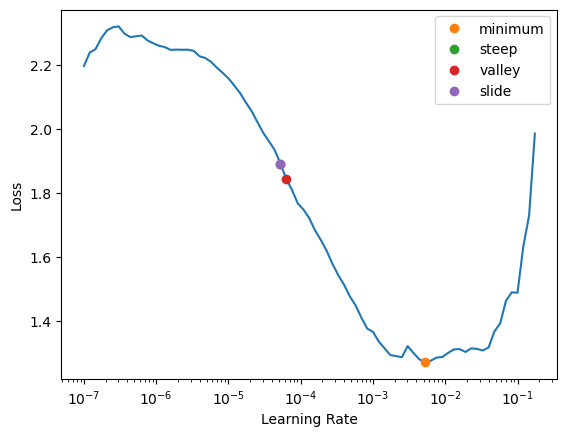

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(1e-5, 1e-3), cbs=fit_cbs)

In [ ]:
print(learn.token_classification_report)

              precision    recall  f1-score   support

         LOC       0.98      0.97      0.97      1130
        MISC       0.89      0.84      0.86       621
         ORG       0.92      0.90      0.91       842
         PER       0.98      0.96      0.97      1208

   micro avg       0.95      0.93      0.94      3801
   macro avg       0.94      0.92      0.93      3801
weighted avg       0.95      0.93      0.94      3801



In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.014615473337471485
valid_loss 0.04145442321896553
accuracy 0.990309097201885
precision 0.953061775020232
recall 0.929492238884504
f1 0.941129461907299


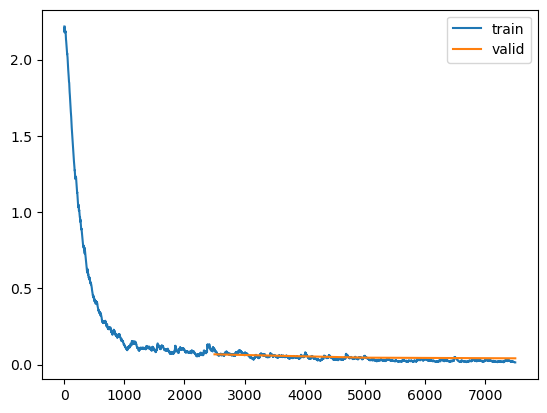

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Hugging Face

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Datasets` (huggingface)

In [ ]:
# define our subword tokenized labeling strategy
labeling_strat = BILabelingStrategy(hf_tokenizer=hf_tokenizer, label_names=label_names)

tokenize_func = partial(
    tokenclass_tokenize_func, hf_tokenizer=hf_tokenizer, labeling_strategy=labeling_strat, words_attr="tokens", word_labels_attr="ner_tags"
)
proc_train_ds = train_ds.map(tokenize_func, batched=True, remove_columns=train_ds.column_names)
proc_valid_ds = valid_ds.map(tokenize_func, batched=True, remove_columns=valid_ds.column_names)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-1df455e7c1724e9a.arrow


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

##### Step 3: `DataLoaders` (PyTorch)

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TokenClassTextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [TokenClassMetricsCallback(hf_tokenizer=hf_tokenizer, label_names=label_names)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    cbs=learn_cbs,
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
b = next(iter(dls.valid))
preds = learn.model(to_device(b[0], hf_model.device))
len(preds), type(preds), preds.keys()

(2,
 transformers.modeling_outputs.TokenClassifierOutput,
 odict_keys(['loss', 'logits']))

In [ ]:
len(b), len(b[0]), b[0]["input_ids"].shape, len(b[1]), b[1].shape, preds.logits.shape

(2, 4, torch.Size([8, 130]), 8, torch.Size([8, 130]), torch.Size([8, 130, 9]))

In [ ]:
print(preds.logits.view(-1, preds.logits.shape[-1]).shape, b[1].view(-1).shape)
test_eq(preds.logits.view(-1, preds.logits.shape[-1]).shape[0], b[1].view(-1).shape[0])

torch.Size([1040, 9]) torch.Size([1040])


#### Step 5: Train

SuggestedLRs(minimum=0.00014454397605732084, steep=5.248074739938602e-05, valley=0.0004786300996784121, slide=5.248074739938602e-05)

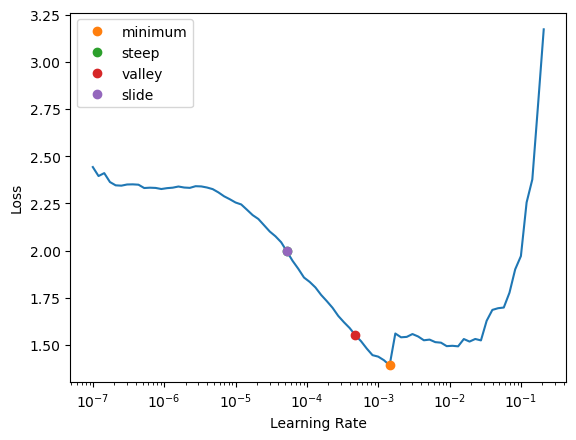

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(1e-5, 1e-3), cbs=fit_cbs)

In [ ]:
print(learn.token_classification_report)

              precision    recall  f1-score   support

         LOC       0.98      0.96      0.97      1136
        MISC       0.89      0.85      0.87       620
         ORG       0.92      0.89      0.91       845
         PER       0.98      0.97      0.98      1199

   micro avg       0.95      0.93      0.94      3800
   macro avg       0.94      0.92      0.93      3800
weighted avg       0.95      0.93      0.94      3800



In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.013830052688717842
valid_loss 0.04201330617070198
accuracy 0.9900428636085301
precision 0.953061775020232
recall 0.9297368421052632
f1 0.9412548288264286


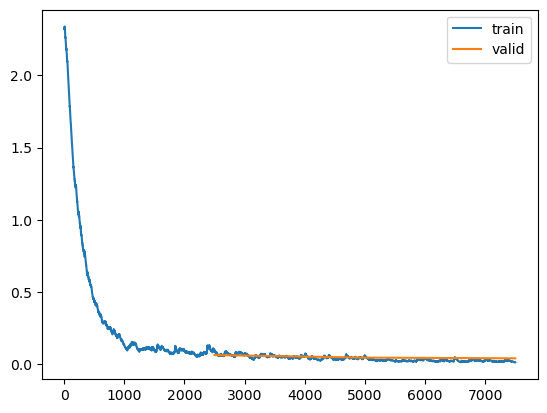

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API

Most of the work to get things compliant with fast.ai's low-level API is already handed in the `data.token_classification` module. In this section, we include a custom `show_results()` method that will work with fast.ai's low-level and mid-level (think `DataBlock`) APIs.

### `show_results` -

In [ ]:
# |export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `TextInput` typed inputs
    x: TokenClassTextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(learner.dls)
    hf_arch, hf_tokenizer = tfm.hf_arch, tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_labels = tfm.kwargs["label_names"] if ("label_names" in tfm.kwargs) else None
    if trg_labels is None and learner.dls.vocab is not None:
        trg_labels = learner.dls.vocab

    res = L()
    n_inp = learner.dls.n_inp

    n_samples = min(max_n, learner.dls.bs)
    for idx in range(n_samples):
        input_ids = x[idx]
        trgs = y[idx]
        pred = outs[idx]
        sample = samples[idx] if samples is not None else None

        # align "tokens" with labels
        tok_labels = get_token_labels_from_input_ids(hf_tokenizer, input_ids, trgs, trg_labels)
        # align "words" with labels
        word_labels = get_word_labels_from_token_labels(hf_arch, hf_tokenizer, tok_labels)
        # align "words" with "predicted" labels
        if isinstance(pred[0], str):
            pred_labels = ast.literal_eval(pred[0])
        elif torch.is_tensor(pred[0]):
            pred_labels = [trg_labels[label_id] for label_id in list(pred[0].numpy())]

        word_pred_labels = [pred_lbl for lbl_id, pred_lbl in zip(trgs, pred_labels) if lbl_id != -100]
        # stringify list of (word,label) for example
        res.append(
            [
                f"{[ (word_targ[0], word_targ[1], pred_targ) for idx, (word_targ, pred_targ) in enumerate(zip(word_labels, word_pred_labels)) if (trunc_at is None or idx < trunc_at) ]}"
            ]
        )

    display_df(pd.DataFrame(res, columns=["token / target label / predicted label"])[:max_n])
    return ctxs

## Low-Level API: Examples

### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


### Step 2: `Datasets` (fastai)

In [ ]:
# define our subword tokenized labeling strategy
labeling_strat = BILabelingStrategy(hf_tokenizer=hf_tokenizer, label_names=label_names)
tokenize_func = partial(
    tokenclass_tokenize_func, hf_tokenizer=hf_tokenizer, labeling_strategy=labeling_strat, words_attr="tokens", word_labels_attr="ner_tags"
)
proc_conll2003_ds = conll2003_ds.map(tokenize_func, batched=True)

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_conll2003_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(train_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

### Step 3: `DataLoaders` (fastai)

In [ ]:
data_collator = TokenClassTextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)
batch_decode_tfm = BatchDecodeTransform(
    hf_tokenizer, hf_arch, hf_config, hf_model, label_names=label_names, input_return_type=TokenClassTextInput
)

dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    after_batch=batch_decode_tfm,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=8, trunc_at=500)

,word / target label
0,"[('7', 'O'), ('-', 'O'), ('Chris', 'B-PER'), ('Walker', 'I-PER'), ('(', 'O'), ('England', 'B-LOC'), (')', 'O'), ('beat', 'O'), ('Julien', 'B-PER'), ('Bonetat', 'I-PER'), ('(', 'O'), ('France', 'B-LOC'), (')', 'O'), ('15-12', 'O')]"
1,"[('1998', 'O'), ('575,000', 'O')]"
2,"[('Turnover', 'O'), ('fell', 'O'), ('to', 'O'), ('937.891', 'O'), ('million', 'O'), ('yuan', 'O'), ('from', 'O'), ('1.215', 'O'), ('billion', 'O'), (',', 'O'), ('while', 'O'), ('net', 'O'), ('assets', 'O'), ('per', 'O'), ('share', 'O'), ('were', 'O'), ('1.88', 'O'), ('yuan', 'O'), (',', 'O'), ('unchanged', 'O'), (',', 'O'), ('and', 'O'), ('earnings', 'O'), ('per', 'O'), ('share', 'O'), ('fell', 'O'), ('to', 'O'), ('0.005', 'O'), ('yuan', 'O'), ('from', 'O'), ('0.02', 'O'), ('yuan', 'O'), (',', 'O'), ('the', 'O'), ('statement', 'O'), ('said', 'O'), ('.', 'O')]"
3,"[('69', 'O'), ('Justin', 'B-PER'), ('Leonard', 'I-PER'), (',', 'O'), ('Mark', 'B-PER'), ('Brooks', 'I-PER')]"


### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [TokenClassMetricsCallback(hf_tokenizer=hf_tokenizer, label_names=label_names)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=learn_cbs,
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 148)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 148 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 148 x 3072      
Linear                         

In [ ]:
b = dls.one_batch()
b

({'input_ids': tensor([[    1,   574,   341,  2753,  6558,   287,  1991,  1263,  2584, 41037,
           14926, 29929,   287,  2378,  1263,   706,   271,  1432,     2,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds), type(preds), preds.keys()

(1,
 transformers.modeling_outputs.TokenClassifierOutput,
 odict_keys(['logits']))

In [ ]:
len(b), len(b[0]), b[0]["input_ids"].shape, len(b[1]), b[1].shape, preds.logits.shape

(2, 3, torch.Size([4, 148]), 4, torch.Size([4, 148]), torch.Size([4, 148, 9]))

In [ ]:
print(preds.logits.view(-1, preds.logits.shape[-1]).shape, b[1].view(-1).shape)
test_eq(preds.logits.view(-1, preds.logits.shape[-1]).shape[0], b[1].view(-1).shape[0])

torch.Size([592, 9]) torch.Size([592])


### Step 5: Train

SuggestedLRs(minimum=0.0005248074419796466, steep=0.0003981071640737355, valley=5.248074739938602e-05, slide=0.0012022644514217973)

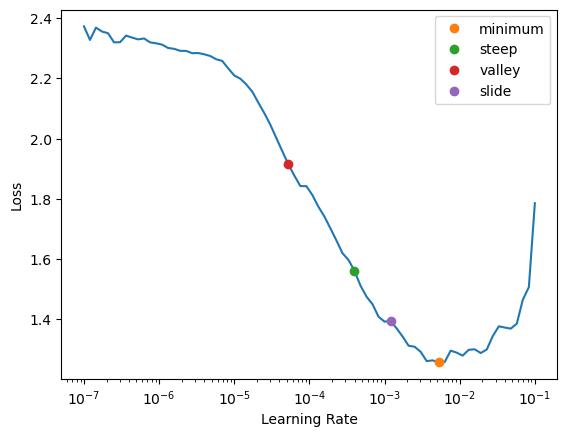

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(1e-5, 1e-3), cbs=fit_cbs)

In [ ]:
print(learn.token_classification_report)

              precision    recall  f1-score   support

         LOC       0.98      0.96      0.97      1133
        MISC       0.89      0.85      0.87       616
         ORG       0.93      0.91      0.92       842
         PER       0.98      0.97      0.98      1194

   micro avg       0.95      0.94      0.94      3785
   macro avg       0.94      0.92      0.93      3785
weighted avg       0.95      0.94      0.94      3785



In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.041616521775722504
valid_loss 0.04060112684965134
accuracy 0.9904688373578978
precision 0.954680334502293
recall 0.935006605019815
f1 0.9447410571276028


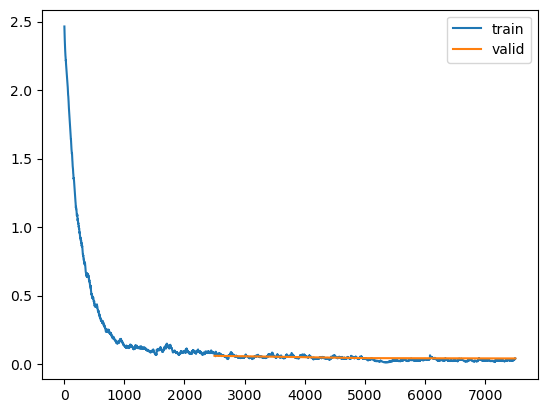

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.export("../models/test_text_tokclass_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Mid-Level API

Everything required to train transformers using the mid-level API is already there, so lets move straight to the examples

## Mid-Level API: Examples

### Pretokenized

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


####  Step 2: `DataBlock`

In [ ]:
# define DataBlock splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)


# define how we want to build our targets
# note: we don't need to define how to build our inputs because we're using an HF `Dataset` in this example
def get_y(example):
    return example["label"]


# define the DataBlock
data_collator = TokenClassTextCollatorWithPadding(hf_tokenizer)

txt_block = TextBlock(
    hf_arch=hf_arch,
    hf_config=hf_config,
    hf_tokenizer=hf_tokenizer,
    hf_model=hf_model,
    input_return_type=TokenClassTextInput,
    data_collator=data_collator,
    batch_decode_kwargs={"label_names": label_names},
)

blocks = (txt_block, noop)
dblock = DataBlock(blocks=blocks, get_y=get_y, splitter=splitter)

#### Step 3: `DataLoaders`

In [ ]:
# define our subword tokenized labeling strategy
labeling_strat = BILabelingStrategy(hf_tokenizer=hf_tokenizer, label_names=label_names)
tokenize_func = partial(
    tokenclass_tokenize_func, hf_tokenizer=hf_tokenizer, labeling_strategy=labeling_strat, words_attr="tokens", word_labels_attr="ner_tags"
)
proc_conll2003_ds = conll2003_ds.map(tokenize_func, batched=True)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98/cache-5da5d73536c0021e.arrow


In [ ]:
dls = dblock.dataloaders(proc_conll2003_ds, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,word / target label
0,"[('7', 'O'), ('-', 'O'), ('Chris', 'B-PER'), ('Walker', 'I-PER'), ('(', 'O'), ('England', 'B-LOC'), (')', 'O'), ('beat', 'O'), ('Julien', 'B-PER'), ('Bonetat', 'I-PER'), ('(', 'O'), ('France', 'B-LOC'), (')', 'O'), ('15-12', 'O')]"
1,"[('(', 'O'), ('Red', 'B-LOC'), ('River', 'I-LOC'), (')', 'O'), ('4.46', 'O'), ('dn', 'O'), ('.02', 'O'), ('5.00', 'O'), ('unc', 'O'), ('--', 'O'), ('--', 'O')]"


#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [TokenClassMetricsCallback(hf_tokenizer=hf_tokenizer, label_names=label_names)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=learn_cbs,
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 148)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 148 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 148 x 3072      
Linear                         

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds), type(preds), preds.keys()

(2,
 transformers.modeling_outputs.TokenClassifierOutput,
 odict_keys(['loss', 'logits']))

In [ ]:
len(b), len(b[0]), b[0]["input_ids"].shape, len(b[1]), b[1].shape, preds.logits.shape

(2, 4, torch.Size([4, 148]), 4, torch.Size([4, 148]), torch.Size([4, 148, 9]))

In [ ]:
print(preds.logits.view(-1, preds.logits.shape[-1]).shape, b[1].view(-1).shape)
test_eq(preds.logits.view(-1, preds.logits.shape[-1]).shape[0], b[1].view(-1).shape[0])

torch.Size([592, 9]) torch.Size([592])


#### Step 5: Train

SuggestedLRs(minimum=0.0001737800776027143, steep=0.00010964782268274575, valley=7.585775892948732e-05, slide=0.0020892962347716093)

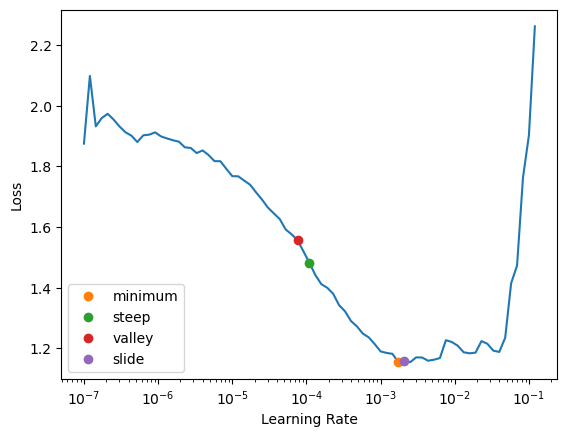

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(1e-5, 1e-3), cbs=fit_cbs)

In [ ]:
print(learn.token_classification_report)

              precision    recall  f1-score   support

         LOC       0.98      0.95      0.96      1149
        MISC       0.88      0.83      0.86       624
         ORG       0.92      0.91      0.91       836
         PER       0.98      0.97      0.98      1192

   micro avg       0.95      0.93      0.94      3801
   macro avg       0.94      0.91      0.93      3801
weighted avg       0.95      0.93      0.94      3801



In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.024398261681199074
valid_loss 0.044275932013988495
accuracy 0.989483773062485
precision 0.9503641758834637
recall 0.9268613522757169
f1 0.9384656366542354


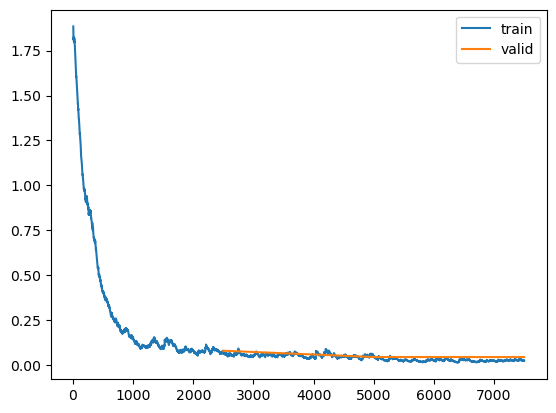

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,token / target label / predicted label
0,"[('HK', 'B-LOC', 'B-LOC'), ('has', 'O', 'O'), ('infrastructure', 'O', 'O'), ('in', 'O', 'O'), ('place', 'O', 'O'), ('for', 'O', 'O'), ('post-97', 'O', 'O'), ('-', 'O', 'O'), ('Tsang', 'B-PER', 'O'), ('.', 'O', 'O')]"
1,"[('Ex-Yankee', 'O', 'O'), ('Randy', 'B-PER', 'I-MISC'), ('Velarde', 'I-PER', 'B-MISC'), ('hit', 'O', 'B-PER'), ('his', 'O', 'I-PER'), ('11th', 'O', 'I-PER'), ('homer', 'O', 'O'), (',', 'O', 'O'), ('his', 'O', 'O'), ('most', 'O', 'O'), ('at', 'O', 'O'), ('any', 'O', 'O'), ('professional', 'O', 'O'), ('level', 'O', 'O'), ('.', 'O', 'O')]"


In [ ]:
learn.export("../models/test_text_tokclass_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Batch-Time Tokenization

#### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	9

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = TokenClassBatchTokenizeTransform(
    hf_arch, hf_config, hf_tokenizer, hf_model, labeling_strategy_cls=BILabelingStrategy, target_label_names=label_names
)

blocks = (TextBlock(tokenize_tfm=tokenize_tfm, input_return_type=TokenClassTextInput), TokenCategoryBlock(vocab=label_names))
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("tokens"),
    get_y=ColReader("ner_tags"),
    splitter=ColSplitter(),
)

In [ ]:
# |hide
# dblock.summary(conll2003_df)

#### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(conll2003_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,word / target label
0,"[('MARKET', 'O'), ('TALK', 'O'), ('-', 'O'), ('USDA', 'B-ORG'), ('net', 'O'), ('change', 'O'), ('in', 'O'), ('weekly', 'O'), ('export', 'O'), ('commitments', 'O'), ('for', 'O'), ('the', 'O'), ('week', 'O'), ('ended', 'O'), ('August', 'O'), ('22', 'O'), (',', 'O'), ('includes', 'O'), ('old', 'O'), ('crop', 'O'), ('and', 'O'), ('new', 'O'), ('crop', 'O'), (',', 'O'), ('were', 'O'), (':', 'O'), ('wheat', 'O'), ('up', 'O'), ('595,400', 'O'), ('tonnes', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('corn', 'O'), ('up', 'O'), ('1,900', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('319,600', 'O'), ('new', 'O'), (';', 'O'), ('soybeans', 'O'), ('down', 'O'), ('12,300', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('300,800', 'O'), ('new', 'O'), (';', 'O'), ('upland', 'O'), ('cotton', 'O'), ('up', 'O'), ('50,400', 'O'), ('bales', 'O'), ('new', 'O'), (',', 'O'), ('nil', 'O'), ('old', 'O'), (';', 'O'), ('soymeal', 'O'), ('54,800', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('100,600', 'O'), ('new', 'O'), (',', 'O'), ('soyoil', 'O'), ('nil', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('75,000', 'O'), ('new', 'O'), (';', 'O'), ('barley', 'O'), ('up', 'O'), ('1,700', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('sorghum', 'O'), ('6,200', 'O'), ('old', 'O'), (',', 'O'), ('up', 'O'), ('156,700', 'O'), ('new', 'O'), (';', 'O'), ('pima', 'O'), ('cotton', 'O'), ('up', 'O'), ('4,000', 'O'), ('bales', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), (';', 'O'), ('rice', 'O'), ('up', 'O'), ('49,900', 'O'), ('old', 'O'), (',', 'O'), ('nil', 'O'), ('new', 'O'), ('...', 'O')]"
1,"[('Shares', 'O'), ('in', 'O'), ('Slough', 'B-ORG'), (',', 'O'), ('which', 'O'), ('earlier', 'O'), ('announced', 'O'), ('a', 'O'), ('14', 'O'), ('percent', 'O'), ('rise', 'O'), ('in', 'O'), ('first-half', 'O'), ('pretax', 'O'), ('profit', 'O'), ('to', 'O'), ('37.4', 'O'), ('million', 'O'), ('stg', 'O'), (',', 'O'), ('climbed', 'O'), ('nearly', 'O'), ('six', 'O'), ('percent', 'O'), (',', 'O'), ('or', 'O'), ('14p', 'O'), ('to', 'O'), ('250', 'O'), ('pence', 'O'), ('at', 'O'), ('1009', 'O'), ('GMT', 'B-MISC'), (',', 'O'), ('while', 'O'), ('British', 'B-ORG'), ('Land', 'I-ORG'), ('added', 'O'), ('12-1', 'O'), ('/', 'O'), ('2p', 'O'), ('to', 'O'), ('468p', 'O'), (',', 'O'), ('Land', 'B-ORG'), ('Securities', 'I-ORG'), ('rose', 'O'), ('5-1', 'O'), ('/', 'O'), ('2p', 'O'), ('to', 'O'), ('691p', 'O'), ('and', 'O'), ('Hammerson', 'B-ORG'), ('was', 'O'), ('8p', 'O'), ('higher', 'O'), ('at', 'O'), ('390', 'O'), ('.', 'O')]"


#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [TokenClassMetricsCallback(hf_tokenizer=hf_tokenizer, label_names=label_names)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=CrossEntropyLossFlat(),
    cbs=learn_cbs,
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 148)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 148 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 148 x 3072      
Linear                         

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds), type(preds), preds.keys()

(1,
 transformers.modeling_outputs.TokenClassifierOutput,
 odict_keys(['logits']))

In [ ]:
len(b), len(b[0]), b[0]["input_ids"].shape, len(b[1]), b[1].shape, preds.logits.shape

(2, 3, torch.Size([4, 148]), 4, torch.Size([4, 148]), torch.Size([4, 148, 9]))

In [ ]:
print(preds.logits.view(-1, preds.logits.shape[-1]).shape, b[1].view(-1).shape)
test_eq(preds.logits.view(-1, preds.logits.shape[-1]).shape[0], b[1].view(-1).shape[0])

torch.Size([592, 9]) torch.Size([592])


#### Step 5: Train

SuggestedLRs(minimum=0.0007585775572806596, steep=4.365158383734524e-05, valley=0.0003981071640737355, slide=0.004365158267319202)

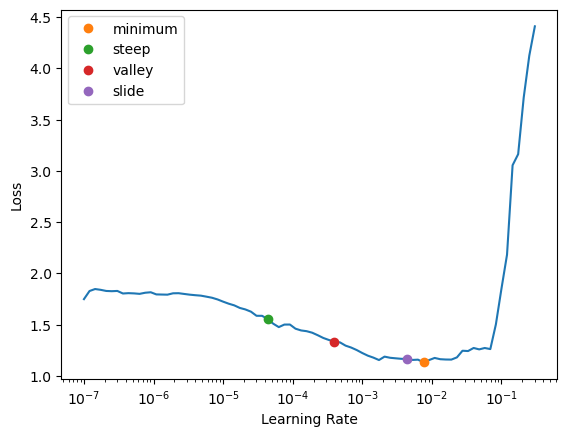

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(1e-5, 1e-3), cbs=fit_cbs)

In [ ]:
print(learn.token_classification_report)

              precision    recall  f1-score   support

         LOC       0.97      0.96      0.96      1132
        MISC       0.88      0.82      0.85       630
         ORG       0.92      0.90      0.91       842
         PER       0.98      0.97      0.98      1197

   micro avg       0.95      0.93      0.94      3801
   macro avg       0.94      0.91      0.93      3801
weighted avg       0.95      0.93      0.94      3801



In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.02436891570687294
valid_loss 0.04526969790458679
accuracy 0.9895370197811559
precision 0.9498246560561101
recall 0.9263351749539595
f1 0.9379328716036227


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,token / target label / predicted label
0,"[('South', 'B-LOC', 'B-LOC'), ('Africa', 'I-LOC', 'I-LOC'), ('-', 'O', 'O'), ('15', 'O', 'O'), ('-', 'O', 'O'), ('Andre', 'B-PER', 'B-PER'), ('Joubert', 'I-PER', 'I-PER'), (',', 'O', 'I-PER'), ('14', 'O', 'O'), ('-', 'O', 'O'), ('Justin', 'B-PER', 'O'), ('Swart', 'I-PER', 'B-PER'), (',', 'O', 'I-PER'), ('13', 'O', 'O'), ('-', 'O', 'O'), ('Japie', 'B-PER', 'O'), ('Mulder', 'I-PER', 'B-PER'), ('(', 'O', 'I-PER'), ('Joel', 'B-PER', 'I-PER'), ('Stransky', 'I-PER', 'O'), (',', 'O', 'B-PER'), ('48', 'O', 'I-PER'), ('mins', 'O', 'I-PER'), (')', 'O', 'O'), ('12', 'O', 'O'), ('-', 'O', 'O'), ('Danie', 'B-PER', 'O'), ('van', 'I-PER', 'O'), ('Schalkwyk', 'I-PER', 'O'), (',', 'O', 'B-PER'), ('11', 'O', 'I-PER'), ('-', 'O', 'I-PER'), ('Pieter', 'B-PER', 'I-PER'), ('Hendriks', 'I-PER', 'I-PER'), (';', 'O', 'I-PER'), ('10', 'O', 'I-PER'), ('-', 'O', 'O'), ('Henry', 'B-PER', 'O'), ('Honiball', 'I-PER', 'O'), (',', 'O', 'B-PER'), ('9', 'O', 'I-PER'), ('-', 'O', 'I-PER'), ('Joost', 'B-PER', 'O'), ('van', 'I-PER', 'O'), ('der', 'I-PER', 'O'), ('Westhuizen', 'I-PER', 'B-PER'), (';', 'O', 'I-PER'), ('8', 'O', 'I-PER'), ('-', 'O', 'I-PER'), ('Gary', 'B-PER', 'O'), ('Teichmann', 'I-PER', 'O'), ('(', 'O', 'O'), ('captain', 'O', 'B-PER'), (')', 'O', 'I-PER'), (',', 'O', 'I-PER'), ('7', 'O', 'I-PER'), ('-', 'O', 'I-PER'), ('Andre', 'B-PER', 'O'), ('Venter', 'I-PER', 'O'), ('(', 'O', 'O'), ('Wayne', 'B-PER', 'B-PER'), ('Fyvie', 'I-PER', 'I-PER'), (',', 'O', 'I-PER'), ('75', 'O', 'O'), (')', 'O', 'O'), (',', 'O', 'O'), ('6', 'O', 'O'), ('-', 'O', 'O'), ('Ruben', 'B-PER', 'O'), ('Kruge', 'I-PER', 'B-PER'), (',', 'O', 'I-PER'), ('5', 'O', 'O'), ('-', 'O', 'B-PER'), ('Mark', 'B-PER', 'I-PER'), ('Andrews', 'I-PER', 'I-PER'), ('(', 'O', 'O'), ('Fritz', 'B-PER', 'O'), ('van', 'I-PER', 'O'), ('Heerden', 'I-PER', 'O'), (',', 'O', 'O'), ('39', 'O', 'O'), (')', 'O', 'B-PER'), (',', 'O', 'I-PER'), ('4', 'O', 'I-PER'), ('-', 'O', 'O'), ('Kobus', 'B-PER', 'O'), ('Wiese', 'I-PER', 'O'), (',', 'O', 'B-PER'), ('3', 'O', 'I-PER'), ('-', 'O', 'O'), ('Marius', 'B-PER', 'B-PER'), ('Hurter', 'I-PER', 'I-PER'), (',', 'O', 'I-PER'), ('2', 'O', 'I-PER'), ('-', 'O', 'O'), ('James', 'B-PER', 'O'), ('Dalton', 'I-PER', 'O'), (',', 'O', 'O'), ('1', 'O', 'O'), ('-', 'O', 'O'), ('Dawie', 'B-PER', 'B-PER'), ('Theron', 'I-PER', 'I-PER'), ('(', 'O', 'I-PER'), ('Garry', 'B-PER', 'O'), ('Pagel', 'I-PER', 'O'), (',', 'O', 'O'), ('66', 'O', 'B-PER'), (')', 'O', 'I-PER'), ('.', 'O', 'I-PER')]"
1,"[('The', 'O', 'O'), ('titles', 'O', 'O'), ('of', 'O', 'O'), ('his', 'O', 'O'), ('other', 'O', 'O'), ('novels', 'O', 'O'), ('translate', 'O', 'O'), ('as', 'O', 'O'), ('""', 'O', 'O'), ('In', 'B-MISC', 'B-PER'), ('the', 'I-MISC', 'O'), ('Year', 'I-MISC', 'I-MISC'), ('of', 'I-MISC', 'O'), ('January', 'I-MISC', 'I-MISC'), ('""', 'O', 'O'), ('(', 'O', 'O'), ('1963', 'O', 'O'), (')', 'O', 'O'), (',', 'O', 'O'), ('""', 'O', 'O'), ('The', 'B-MISC', 'B-MISC'), ('Collapse', 'I-MISC', 'I-MISC'), ('""', 'O', 'O'), ('(', 'O', 'O'), ('1964', 'O', 'O'), (')', 'O', 'O'), (',', 'O', 'O'), ('""', 'O', 'O'), ('Sleeping', 'B-MISC', 'B-MISC'), ('Bread', 'I-MISC', 'I-MISC'), ('""', 'O', 'O'), ('(', 'O', 'O'), ('1975', 'O', 'O'), (')', 'O', 'O'), (',', 'O', 'O'), ('""', 'O', 'O'), ('The', 'B-MISC', 'B-MISC'), ('Decaying', 'I-MISC', 'B-MISC'), ('Mansion', 'I-MISC', 'I-MISC'), ('""', 'O', 'I-MISC'), ('(', 'O', 'O'), ('1977', 'O', 'O'), (')', 'O', 'O'), ('and', 'O', 'O'), ('""', 'O', 'O'), ('A', 'B-MISC', 'O'), ('World', 'I-MISC', 'B-MISC'), ('of', 'I-MISC', 'I-MISC'), ('Things', 'I-MISC', 'I-MISC'), ('""', 'O', 'I-MISC'), ('(', 'O', 'O'), ('1982', 'O', 'O'), (')', 'O', 'O'), (',', 'O', 'O'), ('followed', 'O', 'O'), ('by', 'O', 'O'), ('""', 'O', 'O'), ('The', 'B-MISC', 'O'), ('Knot', 'I-MISC', 'B-MISC'), (',', 'O', 'B-MISC'), ('""', 'O', 'O'), ('""', 'O', 'O'), ('Soul', 'B-MISC', 'O'), ('Alone', 'I-MISC', 'B-ORG'), ('""', 'O', 'I-MISC'), ('and', 'O', 'O'), (',', 'O', 'O'), ('most', '

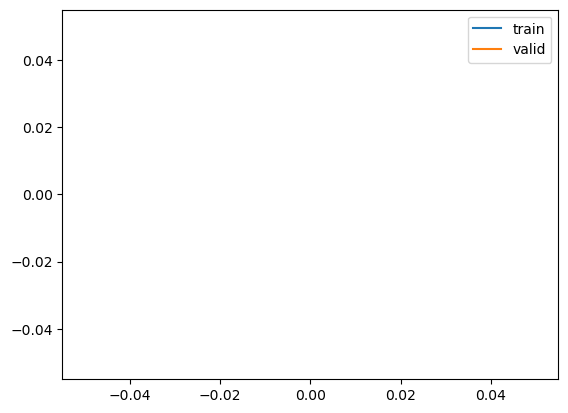

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.export("../models/test_text_tokclass_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Inference

The default `Learner.predict` method returns a prediction per subtoken, including the special tokens for each architecture's tokenizer. Starting with version 2.0 of BLURR, we bring token prediction in-line with Hugging Face's token classification pipeline, both in terms of supporting the same aggregation strategies via Blurr's `TokenAggregationStrategies` class, and also the output via BLURR's `@patch`ed `Learner` method, `blurr_predict_tokens`.

In [ ]:
# |export
class TokenAggregationStrategies:
    """
    Provides the equivalanet of Hugging Face's token classification pipeline's `aggregation_strategy` support across various
    token classication tasks (e.g, NER, POS, chunking, etc...)
    """

    def __init__(
        self,
        hf_tokenizer: PreTrainedTokenizerBase,
        labels: List[str],
        non_entity_label: str = "O",
    ) -> None:
        self.hf_tokenizer = hf_tokenizer
        self.labels = labels
        self.non_entity_label = non_entity_label
        self.valid_strategies = ["simple", "first", "max", "average"]

        self.uses_BI_label_strategy = False
        for lbl in self.labels:
            if lbl.startswith("I-"):
                self.uses_BI_label_strategy = True
                break

    def by_token(self, tokens, input_ids, offsets, preds, probs):
        results = []
        for tok_idx, (token, input_id, offset, pred, prob) in enumerate(zip(tokens, input_ids, offsets, preds, probs)):
            # pass over any non-entity labels and "special" tokens
            label = self.labels[pred]
            if label == self.non_entity_label or input_id.item() in self.hf_tokenizer.all_special_ids:
                continue

            start, end = offset
            results.append(
                {
                    "entity": label,
                    "score": prob[pred],
                    "word": token,
                    "start": start.item(),
                    "end": end.item(),
                }
            )

        return results

    def by_word_strategy(self, strategy_name, text, input_ids, offsets, preds, probs, word_ids=None):
        # validate `strategy_name`
        if strategy_name not in self.valid_strategies:
            raise ValueError("The 'strategy_name' is not supported by this class")

        # validate the existence of `word_ids` if the aggregation strategy = "average"
        if strategy_name == "average" and word_ids is None:
            raise ValueError("The 'average' strategy requires word_ids list")

        results = []
        idx = 0
        while idx < len(preds):
            pred = preds[idx]
            label = self.labels[pred]

            # pass over any non-entity labels and "special" tokens
            if label == self.non_entity_label or input_ids[idx].item() in self.hf_tokenizer.all_special_ids:
                idx += 1
                continue

            # Remove the B- or I-
            label = label[2:] if self.uses_BI_label_strategy else label
            start, end = offsets[idx]

            all_scores = []
            all_scores.append(probs[idx][pred])

            word_scores = {}
            if strategy_name == "average":
                word_scores[word_ids[idx]] = [probs[idx][pred]]

            lbl_to_search = f"I-{label}" if self.uses_BI_label_strategy else label
            while idx + 1 < len(preds) and self.labels[preds[idx + 1]] == lbl_to_search:
                idx += 1
                _, end = offsets[idx]

                pred = preds[idx]

                if strategy_name == "average":
                    if word_ids[idx] in word_scores:
                        word_scores[word_ids[idx]].append(probs[idx][pred])
                    else:
                        word_scores[word_ids[idx]] = [probs[idx][pred]]

                if strategy_name != "first":
                    all_scores.append(probs[idx][pred])

            # The score is the mean of all the scores of the tokens in that grouped entity
            if strategy_name == "average":
                score = np.mean([np.mean(v).item() for k, v in word_scores.items()])
            else:
                score = np.max(all_scores).item() if strategy_name == "max" else np.mean(all_scores).item()

            word = text[start:end]
            results.append(
                {
                    "entity_group": label,
                    "score": score,
                    "word": word,
                    "start": start.item(),
                    "end": end.item(),
                }
            )

            idx += 1

        return results

In [ ]:
# |export
@patch
def blurr_predict_tokens(
    self: Learner,
    # The str (or list of strings) you want to get token classification predictions for
    items: Union[str, List[str]],
    # How entities are grouped and scored
    aggregation_strategy: str = "simple",
    # The label used to idendity non-entity related words/tokens
    non_entity_label: str = "O",
    # If using a slow tokenizer, users will need to prove a `slow_word_ids_func` that accepts a
    # tokenizzer, example index, and a batch encoding as arguments and in turn returnes the
    # equavlient of fast tokenizer's `word_ids``
    slow_word_ids_func: Optional[Callable] = None,
):
    if not is_listy(items):
        items = [items]

    tfm = first_blurr_tfm(self.dls)
    batch_tok_tfm = get_blurr_tfm(self.dls.before_batch, tfm_class=BatchTokenizeTransform)

    hf_tokenizer = tfm.hf_tokenizer

    strategies = TokenAggregationStrategies(hf_tokenizer, self.dls.vocab, non_entity_label)

    inputs = hf_tokenizer(
        items,
        return_offsets_mapping=True,
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    inputs_offsets = inputs["offset_mapping"]
    inputs_input_ids = inputs["input_ids"]

    # run inputs through model
    model_inputs = {k: v.to(self.model.hf_model.device) for k, v in inputs.items()}
    outputs = self.model(model_inputs)

    # fetch probabilities and predictions
    probabilities = F.softmax(outputs.logits, dim=-1).tolist()
    predictions = outputs.logits.argmax(dim=-1).tolist()

    # build our results
    results = []
    for input_idx, (text, input_ids, offsets, preds, probs) in enumerate(
        zip(items, inputs_input_ids, inputs_offsets, predictions, probabilities)
    ):
        # build our results for the current input
        tokens = inputs.tokens(input_idx)
        word_ids = inputs.word_ids(input_idx) if hf_tokenizer.is_fast else slow_word_ids_func(hf_tokenizer, input_idx, inputs)

        if aggregation_strategy == "token":
            results.append(strategies.by_token(tokens, input_ids, offsets, preds, probs))
        else:
            results.append(
                strategies.by_word_strategy(
                    aggregation_strategy,
                    text,
                    input_ids,
                    offsets,
                    preds,
                    probs,
                    word_ids,
                )
            )
    return results

In [ ]:
nbdev.show_doc(Learner.blurr_predict_tokens)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/training/token_classification.py#L313){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_predict_tokens

>      Learner.blurr_predict_tokens (items:Union[str,List[str]],
>                                    aggregation_strategy:str='simple',
>                                    non_entity_label:str='O',
>                                    slow_word_ids_func:Optional[Callable]=None)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| items | Union[str, List[str]] |  | The str (or list of strings) you want to get token classification predictions for |
| aggregation_strategy | str | simple | How entities are grouped and scored |
| non_entity_label | str | O | The label used to idendity non-entity related words/tokens |
| slow_word_ids_func | Optional[Callable] | None | If using a slow tokenizer, users will need to prove a `slow_word_ids_func` that accepts a<br>tokenizzer, example index, and a batch encoding as arguments and in turn returnes the<br>equavlient of fast tokenizer's `word_ids`` |

In [ ]:
export_fname = "../models/test_text_tokclass_mid_level"
inf_learn = load_learner(fname=f"{export_fname}.pkl")

In [ ]:
res = inf_learn.blurr_predict_tokens(
    items=[
        "My name is Wayde and I live in San Diego and using Hugging Face",
        "Bayern Munich is a soccer team in Germany",
    ],
    aggregation_strategy="max",
)

print(len(res))
print(res[1])

2
[{'entity_group': 'ORG', 'score': 0.9990549683570862, 'word': 'Bayern Munich', 'start': 0, 'end': 13}, {'entity_group': 'LOC', 'score': 0.9989032745361328, 'word': ' Germany', 'start': 33, 'end': 41}]


In [ ]:
txt = "Hi! My name is Wayde Gilliam from ohmeow.com. I live in California."
txt2 = "I wish covid was over so I could go to Germany and watch Bayern Munich play in the Bundesliga."

In [ ]:
res = inf_learn.blurr_predict_tokens(txt)
print(res)

[[{'entity_group': 'PER', 'score': 0.998437742392222, 'word': ' Wayde Gilliam', 'start': 14, 'end': 28}, {'entity_group': 'ORG', 'score': 0.607546865940094, 'word': 'com', 'start': 41, 'end': 44}, {'entity_group': 'LOC', 'score': 0.9949468970298767, 'word': ' California', 'start': 55, 'end': 66}]]


In [ ]:
results = inf_learn.blurr_predict_tokens([txt, txt2])
for res in results:
    print(f"{res}\n")

[{'entity_group': 'PER', 'score': 0.998437742392222, 'word': ' Wayde Gilliam', 'start': 14, 'end': 28}, {'entity_group': 'ORG', 'score': 0.607546865940094, 'word': 'com', 'start': 41, 'end': 44}, {'entity_group': 'LOC', 'score': 0.9949468970298767, 'word': ' California', 'start': 55, 'end': 66}]

[{'entity_group': 'LOC', 'score': 0.9990087747573853, 'word': ' Germany', 'start': 38, 'end': 46}, {'entity_group': 'ORG', 'score': 0.9979281425476074, 'word': ' Bayern Munich', 'start': 56, 'end': 70}, {'entity_group': 'MISC', 'score': 0.9702024459838867, 'word': ' Bundesliga', 'start': 82, 'end': 93}]



In [ ]:
# |echo:false
try:
    del inf_learn, hf_model
except:
    pass
finally:
    clean_memory()

## High-Level API

Everything required to train transformers using the mid-level API is already there, so lets move straight to the examples

### `BLearnerForTokenClassification`

`Bleaner`s condense the code required to configure your `Learner` for NLP tasks using BLURR

In [ ]:
# |export
@delegates(Blearner.__init__)
class BlearnerForTokenClassification(Blearner):
    def __init__(self, dls: DataLoaders, hf_model: PreTrainedModel, **kwargs):
        super().__init__(dls, hf_model, **kwargs)

    def predict(self, text):
        return self.blurr_predict_tokens(text)

    def get_metrics_cb(self):
        tfm = first_blurr_tfm(self.dls)

        # if we've included our labels list, we'll use it to look up the value of our target(s)
        trg_labels = tfm.kwargs["label_names"] if ("label_names" in tfm.kwargs) else None
        if trg_labels is None and self.dls.vocab is not None:
            trg_labels = self.dls.vocab

        return TokenClassMetricsCallback(hf_tokenizer=tfm.hf_tokenizer, label_names=trg_labels)

## High-Level API: Examples

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names)

tokenize_tfm = TokenClassBatchTokenizeTransform(
    hf_arch, hf_config, hf_tokenizer, hf_model, labeling_strategy_cls=BILabelingStrategy, target_label_names=label_names
)

blocks = (TextBlock(tokenize_tfm=tokenize_tfm, input_return_type=TokenClassTextInput), TokenCategoryBlock(vocab=label_names))
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("tokens"),
    get_y=ColReader("ner_tags"),
    splitter=ColSplitter(),
)

dls = dblock.dataloaders(conll2003_df, bs=4)

In [ ]:
learn = BlearnerForTokenClassification(dls, hf_model, metrics=[accuracy])
learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.fit_one_cycle(3, 1e-3, cbs=[learn.get_metrics_cb()])

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,token / target label / predicted label
0,"[('South', 'B-LOC', 'B-LOC'), ('Africa', 'I-LOC', 'I-LOC'), ('-', 'O', 'O'), ('15', 'O', 'O'), ('-', 'O', 'O'), ('Andre', 'B-PER', 'B-PER'), ('Joubert', 'I-PER', 'I-PER'), (',', 'O', 'I-PER'), ('14', 'O', 'O'), ('-', 'O', 'O'), ('Justin', 'B-PER', 'O'), ('Swart', 'I-PER', 'B-PER'), (',', 'O', 'I-PER'), ('13', 'O', 'O'), ('-', 'O', 'O'), ('Japie', 'B-PER', 'O'), ('Mulder', 'I-PER', 'B-PER'), ('(', 'O', 'I-PER'), ('Joel', 'B-PER', 'I-PER'), ('Stransky', 'I-PER', 'O'), (',', 'O', 'B-PER'), ('48', 'O', 'I-PER'), ('mins', 'O', 'I-PER'), (')', 'O', 'O'), ('12', 'O', 'O'), ('-', 'O', 'O'), ('Danie', 'B-PER', 'O'), ('van', 'I-PER', 'O'), ('Schalkwyk', 'I-PER', 'O'), (',', 'O', 'B-PER'), ('11', 'O', 'I-PER'), ('-', 'O', 'I-PER'), ('Pieter', 'B-PER', 'I-PER'), ('Hendriks', 'I-PER', 'I-PER'), (';', 'O', 'I-PER'), ('10', 'O', 'I-PER'), ('-', 'O', 'O'), ('Henry', 'B-PER', 'O'), ('Honiball', 'I-PER', 'O'), (',', 'O', 'B-PER'), ('9', 'O', 'I-PER'), ('-', 'O', 'I-PER'), ('Joost', 'B-PER', 'O'), ('van', 'I-PER', 'O'), ('der', 'I-PER', 'O'), ('Westhuizen', 'I-PER', 'B-PER'), (';', 'O', 'I-PER'), ('8', 'O', 'I-PER'), ('-', 'O', 'I-PER'), ('Gary', 'B-PER', 'O'), ('Teichmann', 'I-PER', 'O'), ('(', 'O', 'O'), ('captain', 'O', 'B-PER'), (')', 'O', 'I-PER'), (',', 'O', 'I-PER'), ('7', 'O', 'I-PER'), ('-', 'O', 'I-PER'), ('Andre', 'B-PER', 'O'), ('Venter', 'I-PER', 'O'), ('(', 'O', 'O'), ('Wayne', 'B-PER', 'B-PER'), ('Fyvie', 'I-PER', 'I-PER'), (',', 'O', 'I-PER'), ('75', 'O', 'O'), (')', 'O', 'O'), (',', 'O', 'O'), ('6', 'O', 'O'), ('-', 'O', 'O'), ('Ruben', 'B-PER', 'O'), ('Kruge', 'I-PER', 'B-PER'), (',', 'O', 'I-PER'), ('5', 'O', 'O'), ('-', 'O', 'B-PER'), ('Mark', 'B-PER', 'I-PER'), ('Andrews', 'I-PER', 'I-PER'), ('(', 'O', 'O'), ('Fritz', 'B-PER', 'O'), ('van', 'I-PER', 'O'), ('Heerden', 'I-PER', 'O'), (',', 'O', 'O'), ('39', 'O', 'O'), (')', 'O', 'B-PER'), (',', 'O', 'I-PER'), ('4', 'O', 'I-PER'), ('-', 'O', 'O'), ('Kobus', 'B-PER', 'O'), ('Wiese', 'I-PER', 'O'), (',', 'O', 'B-PER'), ('3', 'O', 'I-PER'), ('-', 'O', 'O'), ('Marius', 'B-PER', 'B-PER'), ('Hurter', 'I-PER', 'I-PER'), (',', 'O', 'I-PER'), ('2', 'O', 'I-PER'), ('-', 'O', 'O'), ('James', 'B-PER', 'O'), ('Dalton', 'I-PER', 'O'), (',', 'O', 'O'), ('1', 'O', 'O'), ('-', 'O', 'O'), ('Dawie', 'B-PER', 'B-PER'), ('Theron', 'I-PER', 'I-PER'), ('(', 'O', 'I-PER'), ('Garry', 'B-PER', 'O'), ('Pagel', 'I-PER', 'O'), (',', 'O', 'O'), ('66', 'O', 'B-PER'), (')', 'O', 'I-PER'), ('.', 'O', 'I-PER')]"
1,"[('The', 'O', 'O'), ('30-year-old', 'O', 'O'), ('Edberg', 'B-PER', 'O'), (',', 'O', 'O'), ('a', 'O', 'O'), ('former', 'O', 'O'), ('two-time', 'O', 'B-PER'), ('Open', 'B-MISC', 'I-PER'), ('champion', 'O', 'O'), (',', 'O', 'O'), ('had', 'O', 'O'), ('wrestled', 'O', 'O'), ('control', 'O', 'O'), ('of', 'O', 'O'), ('the', 'O', 'B-MISC'), ('match', 'O', 'O'), ('away', 'O', 'O'), ('from', 'O', 'O'), ('Karbacher', 'B-PER', 'O'), ('when', 'O', 'O'), ('the', 'O', 'O'), ('German', 'B-MISC', 'O'), (',', 'O', 'O'), ('hampered', 'O', 'O'), ('by', 'O', 'O'), ('a', 'O', 'B-PER'), ('left', 'O', 'I-PER'), ('hamstring', 'O', 'O'), ('injury', 'O', 'O'), (',', 'O', 'B-MISC'), ('decided', 'O', 'O'), ('he', 'O', 'O'), ('could', 'O', 'O'), (""n't"", 'O', 'O'), ('continue', 'O', 'O'), ('under', 'O', 'O'), ('the', 'O', 'O'), ('stadium', 'O', 'O'), ('lights', 'O', 'O'), ('at', 'O', 'O'), ('the', 'O', 'O'), ('National', 'B-LOC', 'O'), ('Tennis', 'I-LOC', 'O'), ('Centre', 'I-LOC', 'O'), ('.', 'O', 'O')]"


In [ ]:
print(learn.token_classification_report)

              precision    recall  f1-score   support

         LOC       0.95      0.90      0.92      1182
        MISC       0.81      0.72      0.76       656
         ORG       0.85      0.81      0.83       863
         PER       0.98      0.96      0.97      1206

   micro avg       0.91      0.87      0.89      3907
   macro avg       0.90      0.85      0.87      3907
weighted avg       0.91      0.87      0.89      3907



In [ ]:
txt = "Hi! My name is Wayde Gilliam from ohmeow.com. I live in California."
txt2 = "I wish covid was over so I could watch Lewandowski score some more goals for Bayern Munich in the Bundesliga."

results = learn.predict([txt, txt2])
for res in results:
    print(f"{res}\n")

[{'entity_group': 'PER', 'score': 0.9953952630360922, 'word': ' Wayde Gilliam', 'start': 14, 'end': 28}, {'entity_group': 'ORG', 'score': 0.783241868019104, 'word': 'com', 'start': 41, 'end': 44}, {'entity_group': 'LOC', 'score': 0.991132915019989, 'word': ' California', 'start': 55, 'end': 66}]

[{'entity_group': 'PER', 'score': 0.9996830224990845, 'word': ' Lewandowski', 'start': 38, 'end': 50}, {'entity_group': 'ORG', 'score': 0.9497816562652588, 'word': ' Bayern Munich', 'start': 76, 'end': 90}, {'entity_group': 'MISC', 'score': 0.8504098653793335, 'word': ' Bundesliga', 'start': 97, 'end': 108}]



In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Export -

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()